In [11]:
using Revise
using RDDIP
using Random
using Plots
using Gurobi
using Statistics
const GRB_ENV = Gurobi.Env()
optimizer=() -> Gurobi.Optimizer(GRB_ENV)

Set parameter Username
Set parameter LicenseID to value 2658456
Academic license - for non-commercial use only - expires 2026-04-28


#11 (generic function with 1 method)

In [ ]:
T = 5
graph=RDDIP.LinearGraph(T);

In [ ]:
function subproblem_builder(instance::RDDIP.Instance, force::Float64, subproblem::Model, node::Int)
    # State variables
    H = [0.0, 50.0, 100.0, 150.0, 200.0]
    V = [0 for i in 1:5]
    V[5] = 1
    @variable(subproblem, volume[i in 1:5], Bin, RDDIP.State, initial_value = V[i])
    # @variable(subproblem, is_on, Bin, RDDIP.State, initial_value = 1)
    # Control variables
    @variables(subproblem, begin
        thermal_generation >= 0
        hydro_generation >= 0
        hydro_spill >= 0
    end)
    # Random variables
    @variable(subproblem, inflow)

    K=9
    Ω = [[k*200/K for k in 1:K] for t in 1:T]
    P = [[1/K for k in 1:K] for t in 1:T]
    Ω[1] = [50.0]
    P[1] = [1.0]
    RDDIP.parameterize(subproblem, Ω[node], P[node]) do ω
        return JuMP.fix(inflow, ω)
    end
    # Transition function and constraints
    @constraints(
        subproblem,
        begin
            sum(H[i] * volume[i].out for i in 1:5) == sum(H[i] * volume[i].in for i in 1:5) - hydro_generation - hydro_spill + inflow
            # thermal_generation <= 150 * is_on.out
            sum(volume[i].out for i in 1:5) == 1
            demand_constraint, hydro_generation + thermal_generation == 150
        end
    )
    # Stage-objective
    @stageobjective(subproblem, 50 * thermal_generation + 60 * hydro_spill)
    return subproblem
end

In [6]:
model = RDDIP.PolicyGraph(
    subproblem_builder,
    instance,
    0.0,
    graph;
    sense = :Min,
    lower_bound = 0.0,
    optimizer = optimizer,
)

UndefVarError: UndefVarError: `subproblem_builder` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
# println(model[1].subproblem)
model[2].noise_terms

In [ ]:
# RDDIP.train(model; iteration_limit = 5, duality_handler = RDDIP.ContinuousConicDuality())
RDDIP.train(model; iteration_limit = 100, duality_handler = RDDIP.LagrangianDuality())
# RDDIP.train(model; iteration_limit = 100, duality_handler = RDDIP.StrengthenedConicDuality())

In [12]:
instance=RDDIP.parse_nc4("Data/T-Ramp/10_0_1_w.nc4",  optimizer, 24); instance.N

1

In [42]:
res=RDDIP.bin_extensive_neutral_integer(instance; K=4, silent=false,  Tmax=2, force=0.0, S=1, batch=1, gap=0.001, timelimit=10);

Set parameter TimeLimit to value 10
Set parameter Threads to value 1
Set parameter MIPGap to value 0.001
Set parameter MIPGap to value 0.001
Set parameter Threads to value 1
Set parameter TimeLimit to value 10
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 22 physical cores, 22 logical processors, using up to 1 threads

Non-default parameters:
TimeLimit  10
MIPGap  0.001
Threads  1

Optimize a model with 3488 rows, 2557 columns and 12322 nonzeros
Model fingerprint: 0x52945434
Variable types: 827 continuous, 1730 integer (1730 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 285 rows and 224 columns
Presolve time: 0.02s
Presolved: 3203 rows, 2333 columns, 13109 nonzeros
Variable types: 516 continuous, 1817 integer (1584 binary)
Fo

In [ ]:
RDDIP.bin_extensive_neutral(instance; silent=false,  force=1.0, S=20, batch=1, gap=0.001, timelimit=10);

In [ ]:
resSP=RDDIP.benders_callback(instance, RDDIP.extended_BD_FH_OH, silent=false, force=1.0, S=20, batch=1, gap=0.1, timelimit=120);

In [17]:
T = 24
graph=RDDIP.LinearGraph(T);

In [ ]:
force = 1.0
model = RDDIP.PolicyGraph(
    RDDIP.subproblem_builder_UC,
    instance,
    force,
    graph,
    sense = :Min,
    lower_bound = 0.0,
    optimizer = optimizer,
)

Min 43.169962 power_real[1] + 300 power_shedding[1] + 300 power_curtailement[1] + 1337.77358 is_on[1]_out + 172.862432 start_up[1] + _[23]
Subject to
 32 power_integer[1,1]_out + 60.66666666666667 power_integer[1,2]_out + 89.33333333333334 power_integer[1,3]_out + 118 power_integer[1,4]_out + power_dev[1] - power_real[1] = 0
 32 power_integer[1,1]_out + 60.66666666666667 power_integer[1,2]_out + 89.33333333333334 power_integer[1,3]_out + 118 power_integer[1,4]_out - power[1] = 0
 32 power_integer[1,1]_in + 60.66666666666667 power_integer[1,2]_in + 89.33333333333334 power_integer[1,3]_in + 118 power_integer[1,4]_in - power_prev[1] = 0
 -is_on[1]_out + power_integer[1,1]_out + power_integer[1,2]_out + power_integer[1,3]_out + power_integer[1,4]_out = 0
 -is_on[1]_in + power_integer[1,1]_in + power_integer[1,2]_in + power_integer[1,3]_in + power_integer[1,4]_in = 0
 -is_on[1]_in + is_on[1]_out - start_up[1] + start_down[1] = 0
 uncertainty[1] + uncertainty[2] = 1
 error_forecast[1] + unce

A policy graph with 24 nodes.
 Node indices: 1, ..., 24


In [50]:
# println(JuMP.upper_bound(collect(values(model[2].states))[1].in))
# println(model[2].lagrangian)
cut = model[24].lagrangian.cuts
# cut.outgoing_state_values[Symbol("power_integer[7,1]")]

RDDIP.Cut2[]

In [44]:
Random.seed!(12345)
# RDDIP.train(model; iteration_limit = 1, duality_handler = RDDIP.StrengthenedConicDuality())
RDDIP.train(model; iteration_limit = 1, duality_handler = RDDIP.LagrangianConicDuality())

-------------------------------------------------------------------
         RDDIP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 24
  state variables : 5
  scenarios       : 8.38861e+06
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : RDDIP.Expectation()
  sampling scheme : RDDIP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [22, 23]
  AffExpr in MOI.EqualTo{Float64}         : [9, 9]
  AffExpr in MOI.GreaterThan{Float64}     : [3, 8]
  AffExpr in MOI.LessThan{Float64}        : [7, 12]
  VariableRef in MOI.GreaterThan{Float64} : [6, 11]
  VariableRef in MOI.LessThan{Float64}    : [5, 6]
  VariableRef in MOI.ZeroOne              : [8, 9]
numerical stability report
  matrix range     [5e-01, 1e+02]
  objective range  [1e+00, 1e+03]
  bounds range     [1e+00, 1e+00]
  rhs range        [1e+00, 1e+03]
----------------------

BoundsError: BoundsError: attempt to access Tuple{Nothing, Nothing} at index [3]

In [ ]:
RDDIP.TrainingResults(:iteration_limit, RDDIP.Log[RDDIP.Log(1, 1.428402521661652e6, 1.8350314844269806e6, 3.765532970428467, 1, 140, "S", false), RDDIP.Log(2, 1.4869460945114475e6, 1.9150885666642494e6, 9.079401969909668, 1, 280, "S", false)])

In [ ]:
res=RDDIP.train(model; iteration_limit = 2, print_level = 0, duality_handler = RDDIP.RDDIP.LagrangianConicDuality())

In [28]:
# string([res.log[i].simulation_value for i in 1:length(res.log)])
1.8574247832686587e6

1.8574247832686587e6

In [ ]:
println(model[23].subproblem)

In [ ]:
println(model[23].subproblem)
# mod = model[23].subproblem
# optimize!(mod)

In [ ]:
node = model[23]
for (key, state) in node.states
    # println((key, value(state.in), JuMP.is_integer(state.in), JuMP.upper_bound(state.in)))
    println((key, state.out, JuMP.is_binary(state.out), node.incoming_state_bounds[key]))
    # println((key, value(state.in), JuMP.is_integer(state.in)))
    # println(JuMP.upper_bound(state.in))
end
JuMP.upper_bound(collect(values(node.states))[1].in)
# collect(values(node.states))[1].in


In [ ]:
println(model[1].subproblem)

In [ ]:
1.806476027737761e6, 1.8289582420327545e6

In [61]:
mod = JuMP.Model(optimizer)
@variable(mod, x, Bin)
@variable(mod, y )
@objective(mod, Max, x)
# JuMP.optimize!(mod)
# JuMP.termination_status(mod)
undo_relax = JuMP.relax_integrality(mod)
println(mod)
# undo_relax()
# JuMP.upper_bound(x)
using Dualization
md=dualize(mod)
println(md)

Max x
Subject to
 x ≥ 0
 x ≤ 1

Min -_[1]
Subject to
 0 = 0
 -_[1] ≥ 1
 _[1] ≤ 0



In [111]:
using Dualization
mod = JuMP.Model(optimizer)
@variable(mod, x)
@variable(mod, y)
@constraint(mod, s,x + y <= 10)
@objective(mod, Min, x)

new_model, reference_map = copy_model(mod)
@constraint(new_model, fix_x, reference_map[x] == 1.0)
println(new_model)

md=dualize(new_model; dual_names = DualNames("dual_var_", "dual_con_"))
# println(md)
# reference_map[s]
hexpr = JuMP.objective_function(md)
println(md)
@variable(md, z)
@constraint(md, z <= hexpr)
@objective(md, Max, z)
println(md)
md[Symbol("dual_var_", "s")]

Min x
Subject to
 fix_x : x = 1
 s : x + y ≤ 10

Max 10 dual_var_s + dual_var_fix_x
Subject to
 dual_con_x : dual_var_fix_x + dual_var_s = 1
 dual_con_y : dual_var_s = 0
 dual_var_s ≤ 0

Max z
Subject to
 dual_con_x : dual_var_fix_x + dual_var_s = 1
 dual_con_y : dual_var_s = 0
 -dual_var_fix_x - 10 dual_var_s + z ≤ 0
 dual_var_s ≤ 0



dual_var_s

In [34]:
using Suppressor, Dualization
node = model[24]
mod = node.subproblem
undo_relax = JuMP.relax_integrality(mod)
new_model, reference_map = @suppress copy_model(mod)
undo_relax()
copy_state_out = Dict()
copy_state_in = Dict()
copy_uncertainty = Dict()
for (name,state) in node.states
    copy_state_out[name] = JuMP.variable_by_name(new_model, string(name,"_out"))
    copy_state_in[name] = JuMP.variable_by_name(new_model, string(name,"_in"))
end
for (name,uncertainty) in node.uncertainties
    # println(name, uncertainty)
    copy_uncertainty[name] = JuMP.variable_by_name(new_model, string(name))
end
@constraint(new_model, fix_out[name in keys(copy_state_out)], copy_state_out[name] == 0.0)
@constraint(new_model, fix_in[name in keys(copy_state_in)], copy_state_in[name] == 0.0)
@constraint(new_model, fix_uncertainty[name in keys(copy_uncertainty)], copy_uncertainty[name] == 0.0)
println(new_model)
md=dualize(new_model; consider_constrained_variables=false, dual_names = DualNames("dual_var_", "dual_con_"))
hexpr = JuMP.objective_function(md)
@variable(md, θ)
@constraint(md, θ <= hexpr)
@objective(md, Max, θ)
println(md)
dual_variables_states_out = Dict(name => md[Symbol("dual_var_fix_out[$name]")] for name in keys(copy_state_out))
dual_variables_states_in = Dict(name => md[Symbol("dual_var_fix_in[$name]")] for name in keys(copy_state_in))
dual_variables_uncertainty = Dict(name => md[Symbol("dual_var_fix_uncertainty[$name]")] for name in keys(copy_uncertainty))

Min 43.169962 power_real[1] + 300 power_shedding[1] + 300 power_curtailement[1] + 1337.77358 is_on[1]_out + 172.862432 start_up[1] + _[23]
Subject to
 32 power_integer[1,1]_out + 60.66666666666667 power_integer[1,2]_out + 89.33333333333334 power_integer[1,3]_out + 118 power_integer[1,4]_out + power_dev[1] - power_real[1] = 0
 32 power_integer[1,1]_out + 60.66666666666667 power_integer[1,2]_out + 89.33333333333334 power_integer[1,3]_out + 118 power_integer[1,4]_out - power[1] = 0
 32 power_integer[1,1]_in + 60.66666666666667 power_integer[1,2]_in + 89.33333333333334 power_integer[1,3]_in + 118 power_integer[1,4]_in - power_prev[1] = 0
 -is_on[1]_out + power_integer[1,1]_out + power_integer[1,2]_out + power_integer[1,3]_out + power_integer[1,4]_out = 0
 -is_on[1]_in + power_integer[1,1]_in + power_integer[1,2]_in + power_integer[1,3]_in + power_integer[1,4]_in = 0
 -is_on[1]_in + is_on[1]_out - start_up[1] + start_down[1] = 0
 uncertainty[1] + uncertainty[2] = 1
 error_forecast[1] + unce

Dict{Symbol, VariableRef} with 2 entries:
  Symbol("uncertainty[1]") => dual_var_fix_uncertainty[uncertainty[1]]
  Symbol("uncertainty[2]") => dual_var_fix_uncertainty[uncertainty[2]]

In [24]:
string(all_variables(md)[1])

"_[1]"

In [8]:
using JuMP, Dualization
model = Model()
@variable(model, x)
@variable(model, y)
@variable(model, z)
@constraint(model, soccon, [x; y; z] in SecondOrderCone())
@constraint(model, eqcon, x == 1)
@objective(model, Min, y + z)
dual_model = dualize(model; consider_constrained_variables=false, dual_names = DualNames("", ""))
println(dual_model)

Max eqcon
Subject to
 x : eqcon + soccon_1 = 0
 y : soccon_2 = 1
 z : soccon_3 = 1
 [soccon_1, soccon_2, soccon_3] ∈ MathOptInterface.SecondOrderCone(3)



In [65]:
new_model

A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 23
├ num_constraints: 68
│ ├ AffExpr in MOI.EqualTo{Float64}: 21
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 12
│ ├ VariableRef in MOI.EqualTo{Float64}: 7
│ ├ VariableRef in MOI.GreaterThan{Float64}: 13
│ └ VariableRef in MOI.LessThan{Float64}: 7
└ Names registered in the model
  └ :error_forecast, :fix_in, :fix_out, :fix_uncertainty, :flow, :power, :power_curtailement, :power_dev, :power_prev, :power_real, :power_shedding, :start_down, :start_up, :θ

In [66]:
dualize(new_model)

A JuMP Model
├ solver: none
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 51
├ num_constraints: 46
│ ├ AffExpr in MOI.EqualTo{Float64}: 6
│ ├ AffExpr in MOI.GreaterThan{Float64}: 13
│ ├ VariableRef in MOI.GreaterThan{Float64}: 8
│ └ VariableRef in MOI.LessThan{Float64}: 19
└ Names registered in the model: none

In [74]:
using JuMP, Dualization, LinearAlgebra

# Ton modèle original
model = Model()
@variable(model, x1 >= 0)
@variable(model, x2)
@constraint(model, x2 == 4)
@constraint(model, 2x1 - x2 >= 1)
@constraint(model, x1 + x2 <= 3)
@objective(model, Min, x1 + 2x2)

# --- Étape 1 : standardiser ---
# Dualization.jl fournit un utilitaire pour cela :
# standard_model = Dualization.standard_form(model)

# --- Étape 2 : dualiser ---
dual_model = dualize(model)

println("Nb variables primal standardisé: ", num_variables(model))
# println("Nb contraintes dual: ", num_constraints(dual_model))
println(dual_model)

Nb variables primal standardisé: 2
Max _[2] + 3 _[3] + 4 _[1]
Subject to
 _[1] - _[2] + _[3] = 2
 -2 _[2] - _[3] ≥ -1
 _[2] ≥ 0
 _[3] ≤ 0



In [59]:
println(model[2].lagrangian.model)

Max theta_2
Subject to
 dual_con_power_dev[1] : _[1] + _[22] + _[30] = 0
 dual_con_θ[1] : 0 = 0
 dual_con_error_forecast[1] : _[8] - 44.209449242 _[9] = 0
 dual_con_uncertainty[2] : _[7] + 0.5 _[8] + dual_var_fix_uncertainty[uncertainty[2]] + _[42] = 0
 dual_con_start_down[1] : -_[6] - _[32] - 32.599073 _[36] - _[46] ≥ 0
 dual_con_start_up[1] : _[6] - _[31] - 42.003808 _[35] - _[45] ≥ -172.862432
 dual_con_power_integer[1,4]_out : -118 _[1] - 118 _[2] - _[4] - dual_var_fix_out[power_integer[1,4]] - _[54] ≥ 0
 dual_con_power[1] : _[2] - _[23] - _[33] ≥ 0
 dual_con_ : 0 ≥ -1
 dual_con_power_integer[1,3]_in : -89.33333333333334 _[3] - _[5] - dual_var_fix_in[power_integer[1,3]] - _[27] - _[39] - _[51] ≥ 0
 dual_con_power_integer[1,1]_out : -32 _[1] - 32 _[2] - _[4] - dual_var_fix_out[power_integer[1,1]] - _[48] ≥ 0
 dual_con_power_curtailement[1] : _[9] ≥ -300
 dual_con_power_integer[1,2]_out : -60.66666666666667 _[1] - 60.66666666666667 _[2] - _[4] - dual_var_fix_out[power_integer[1,2]] -

In [ ]:
mod = model[2].lagrangian.model
# set_optimizer(mod, optimizer)
set_optimizer_attribute(mod, "Presolve", 0)
println(mod)
unset_silent(mod)  # Remet les sorties du solveur
optimize!(mod)
println("Termination status: ", JuMP.termination_status(mod))
println("Primal status:     ", JuMP.primal_status(mod))
Dict(i =>value.(var) for (i, var) in model[2].lagrangian.dual_variables)
for (i, var) in model[2].lagrangian.dual_variables
    if abs(value(var)) > 1e-6
        println("Variable ", i, " has value ", value(var))
    end
end
println(value(model[2].lagrangian.theta))

In [20]:
using XLSX

# Ouvre le fichier Excel
xlsx = XLSX.readxlsx("results_1000.xlsx")

XLSXFile("results_1000.xlsx") containing 1 Worksheet
            sheetname size          range        
-------------------------------------------------
              results 5x4           A1:D5        


In [21]:
Lower_bound = Dict()
for i in 2:5
    name = xlsx["results"]["A$i"]
    A = xlsx["results"]["B$i"]
    B = parse.(Float64, split(strip(A, ['[', ']']), ","))
    Lower_bound[name] = B
end

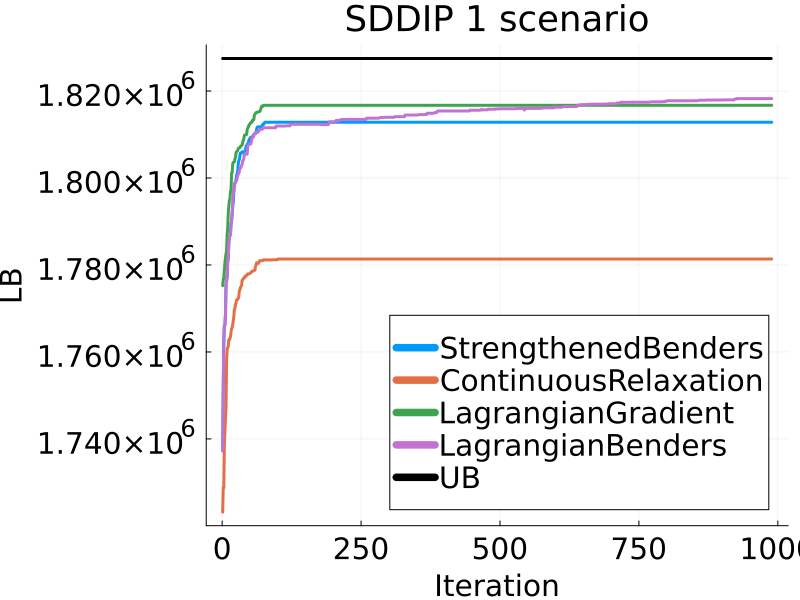

"/home/mathis/Documents/RDDIP/SDDIP1.png"

In [45]:
K=12
using Plots
p = plot(title="SDDIP 1 scenario",
     xlabel="Iteration",
     ylabel="LB",
    #  lw=2,                # largeur des lignes
     legend=:bottomright,
    titlefontsize=24, 
    guidefontsize=20, 
    tickfontsize=20, 
    legendfontsize=20,
    size=(800, 600),
    linewidth=3, )     # position de la légende

for (nom, valeurs) in Lower_bound
    plot!(1:length(valeurs[K:end]), valeurs[K:end], label=nom, linewidth=3)
end
plot!([N for N in 1:1000-K], [1827475 for N in 1:1000-K], color=:black, linewidth=3, label="UB")

display(p)
savefig("SDDIP1.png")